In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

from qiskit import Aer, execute
from qiskit.circuit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
from skimage import data
from skimage.color import rgb2gray
from skimage.transform import resize

from neqr import NEQR

In [2]:
astronaut = data.astronaut()

In [3]:
astronaut.shape

(512, 512, 3)

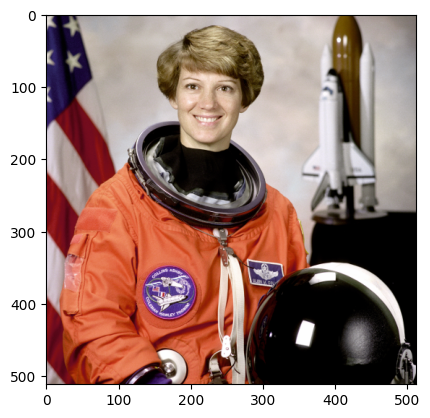

In [4]:
plt.imshow(astronaut)
plt.show()

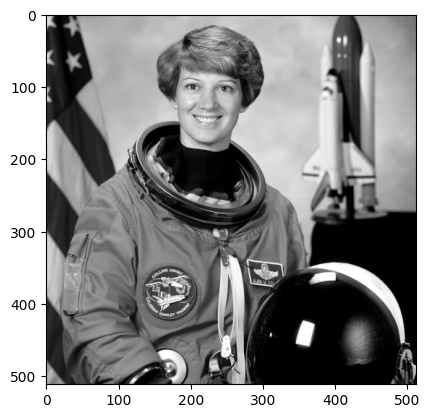

In [5]:
gray_astro = rgb2gray(astronaut)
plt.imshow(gray_astro, cmap="gray")
plt.show()

In [6]:
# brain = data.brain()
# plt.imshow(brain[0,:,:], cmap="gray")
# plt.show()

In [7]:
resized_gray_astro = resize(gray_astro, (2,2))

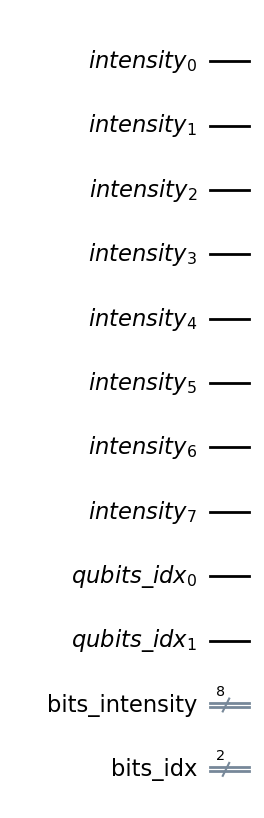

In [8]:
qubits_idx = QuantumRegister(size=2, name="qubits_idx")
intensity = QuantumRegister(size=8, name="intensity")
bits_idx = ClassicalRegister(size=2, name="bits_idx")
bits_intensity = ClassicalRegister(size=8, name="bits_intensity")

qc = QuantumCircuit(intensity, qubits_idx, bits_intensity, bits_idx)
qc.draw(output="mpl")

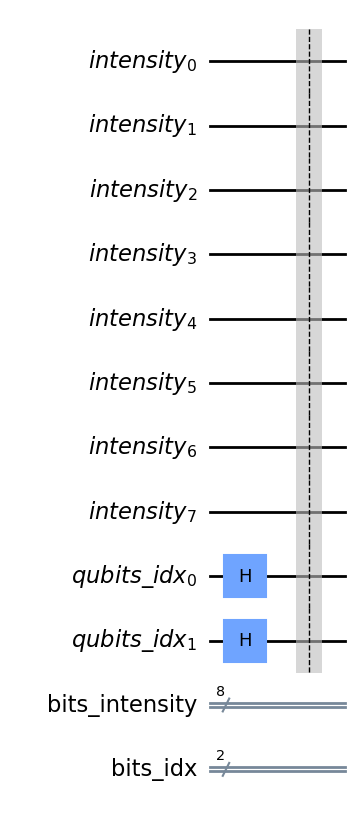

In [9]:
qc.h(qubit=qubits_idx)
qc.barrier()
qc.draw(output="mpl")

In [10]:
pixel_pos_intensity = []

for row in resized_gray_astro:
    for item in row:
        pixel_pos_intensity.append(int(np.round(255*item)))
        
bin_list = [bin(num)[2:] for num in pixel_pos_intensity]

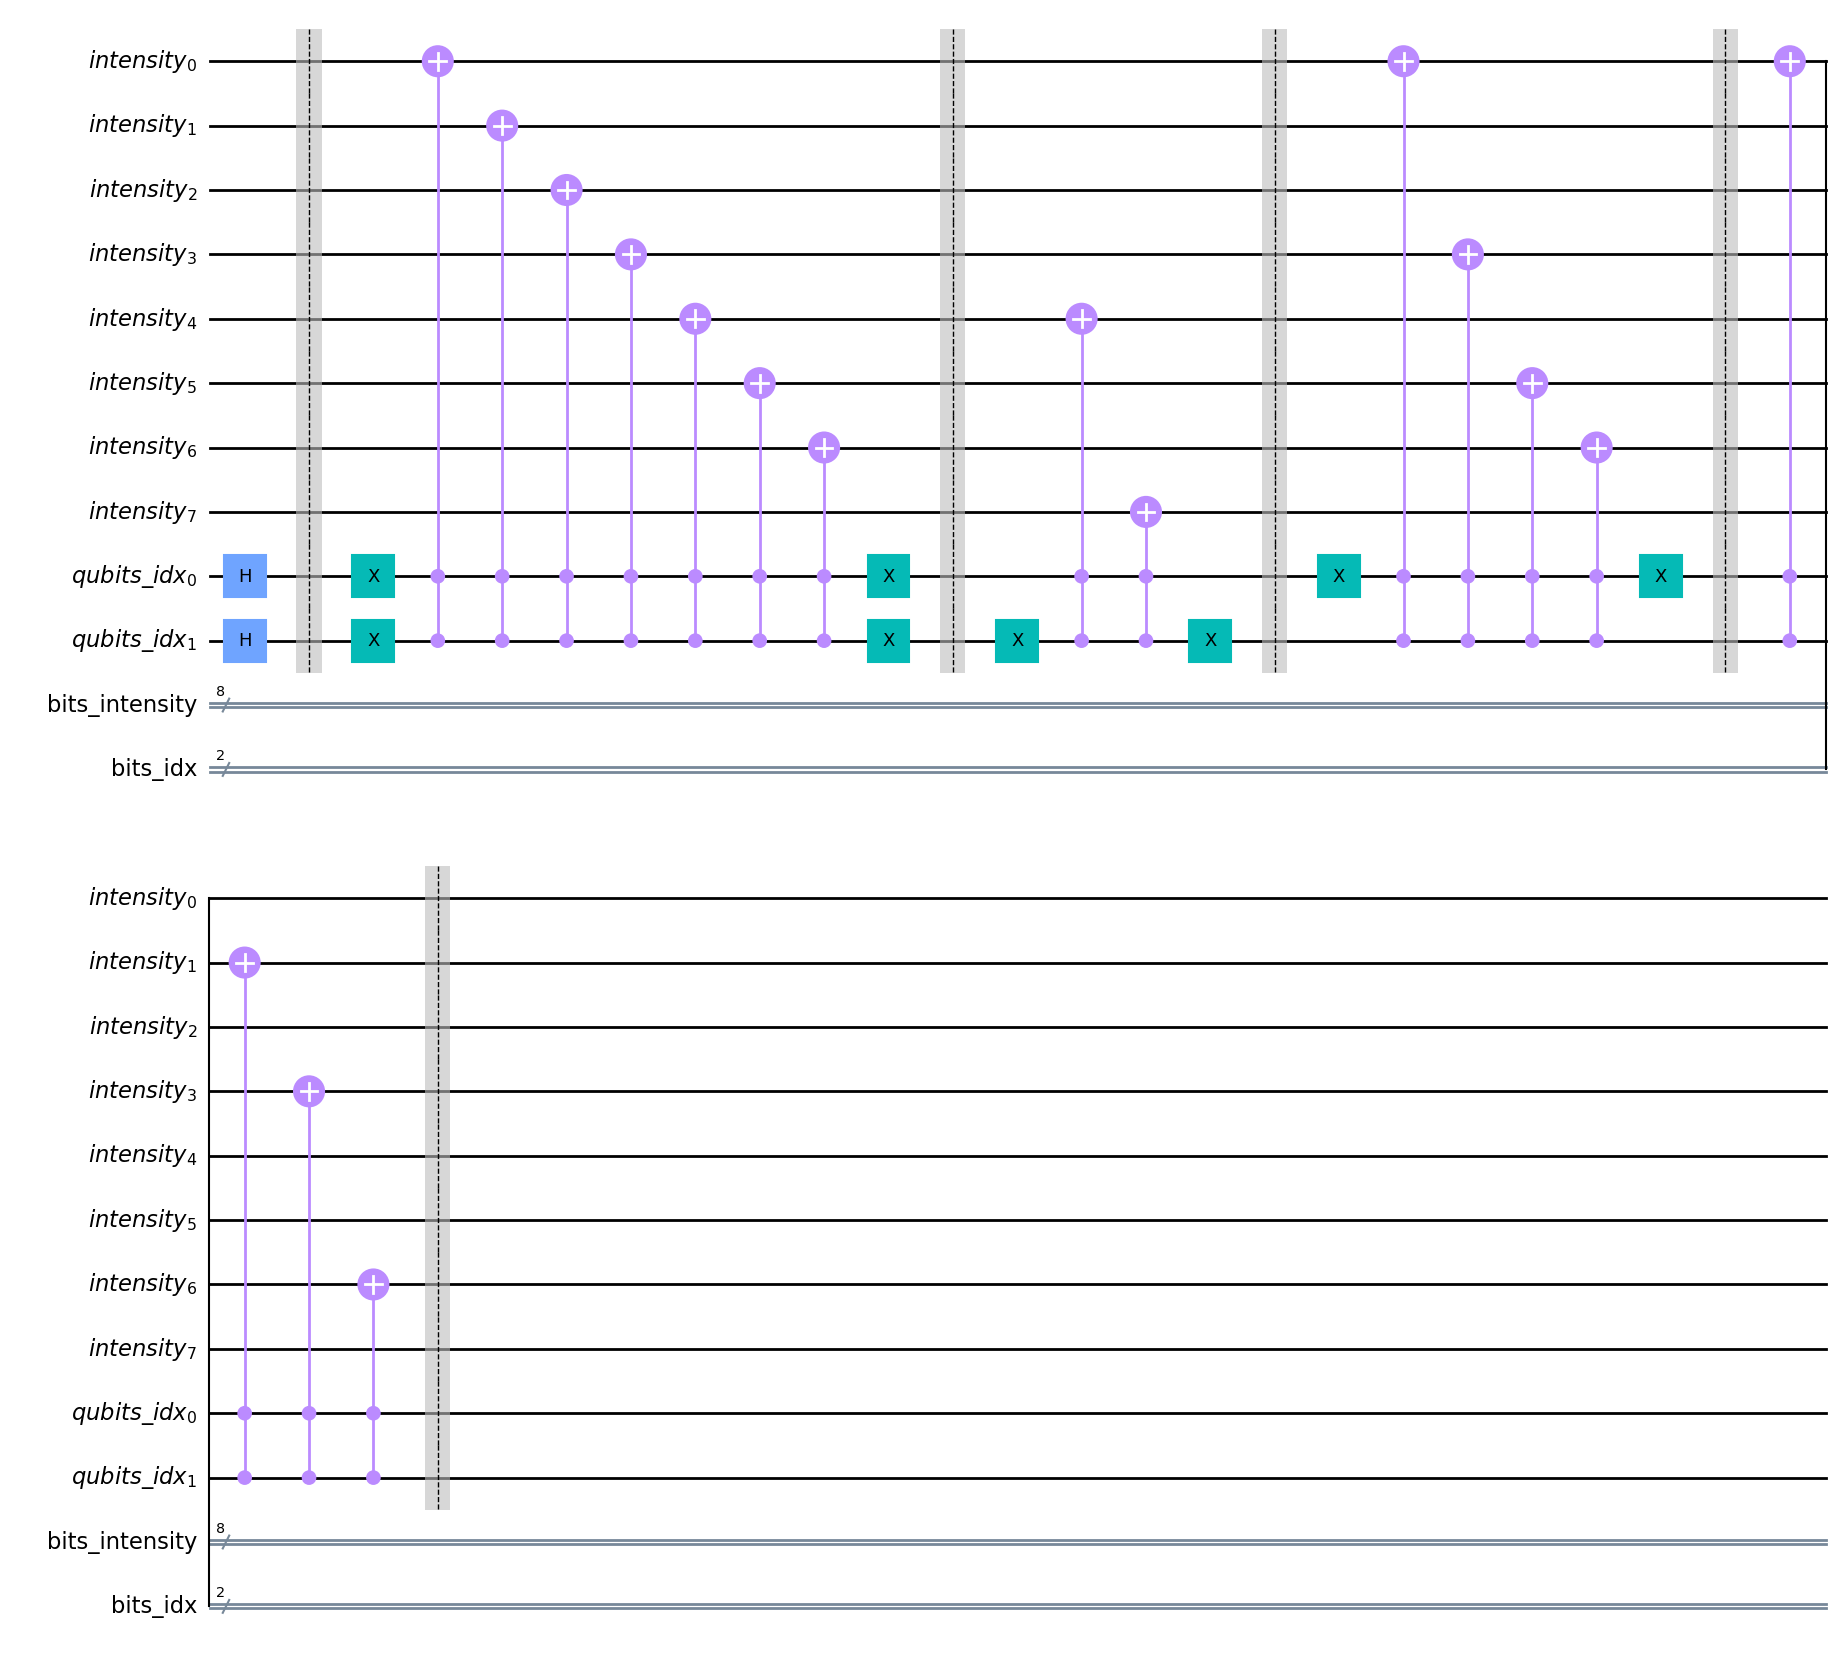

In [11]:
for idx, bnum in enumerate(bin_list):
    
    if idx == 0:
        qc.x(qubit=qubits_idx)
        for pos, item in enumerate(bnum[::-1]):
            if item == "1":
                qc.mct(control_qubits=qubits_idx, target_qubit=intensity[pos])
        qc.x(qubit=qubits_idx)
        qc.barrier()
    elif idx == 1:
        qc.x(qubit=qubits_idx[1])
        for pos, item in enumerate(bnum[::-1]):
            if item == "1":
                qc.mct(control_qubits=qubits_idx, target_qubit=intensity[pos])
        qc.x(qubit=qubits_idx[1])
        qc.barrier()
    elif idx == 2:
        qc.x(qubit=qubits_idx[0])
        for pos, item in enumerate(bnum[::-1]):
            if item == "1":
                qc.mct(control_qubits=qubits_idx, target_qubit=intensity[pos])
        qc.x(qubit=qubits_idx[0])
        qc.barrier()
    else:
        for pos, item in enumerate(bnum[::-1]):
            if item == "1":
                qc.mct(control_qubits=qubits_idx, target_qubit=intensity[pos])
        qc.barrier()
        
qc.draw(output="mpl")

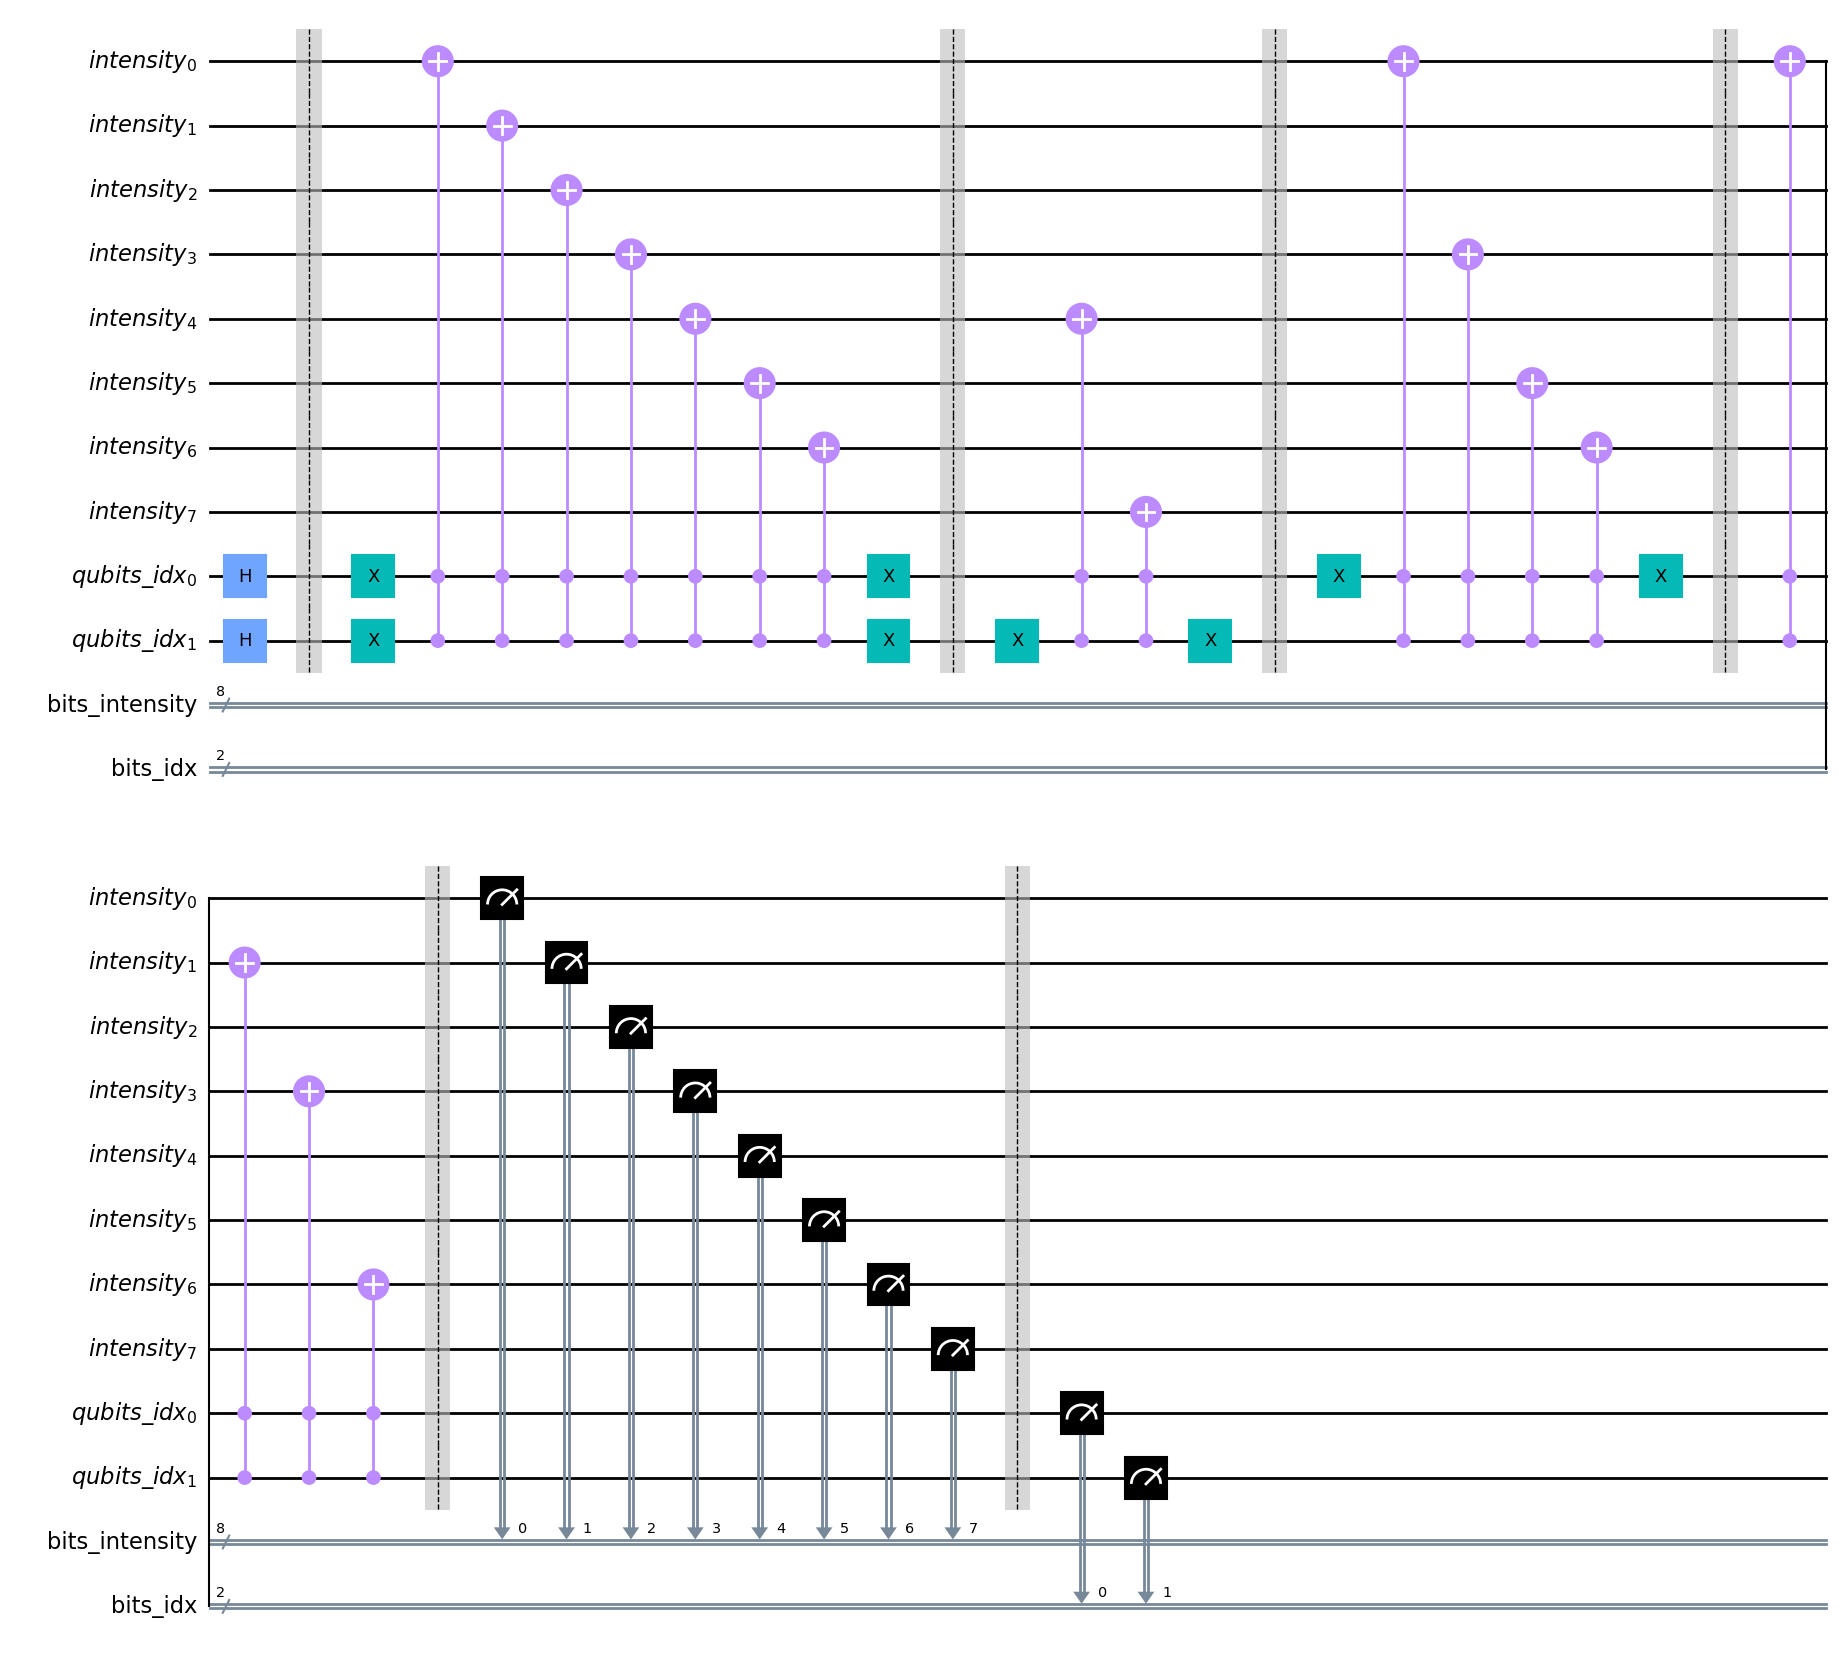

In [12]:
qc.measure(qubit=intensity, cbit=bits_intensity)
qc.barrier()
qc.measure(qubit=qubits_idx, cbit=bits_idx)
qc.draw(output="mpl")

In [13]:
image_neqr = NEQR()

qcircuit = image_neqr.image_quantum_circuit(gray_scale_image_array=resized_gray_astro, measurements=True)

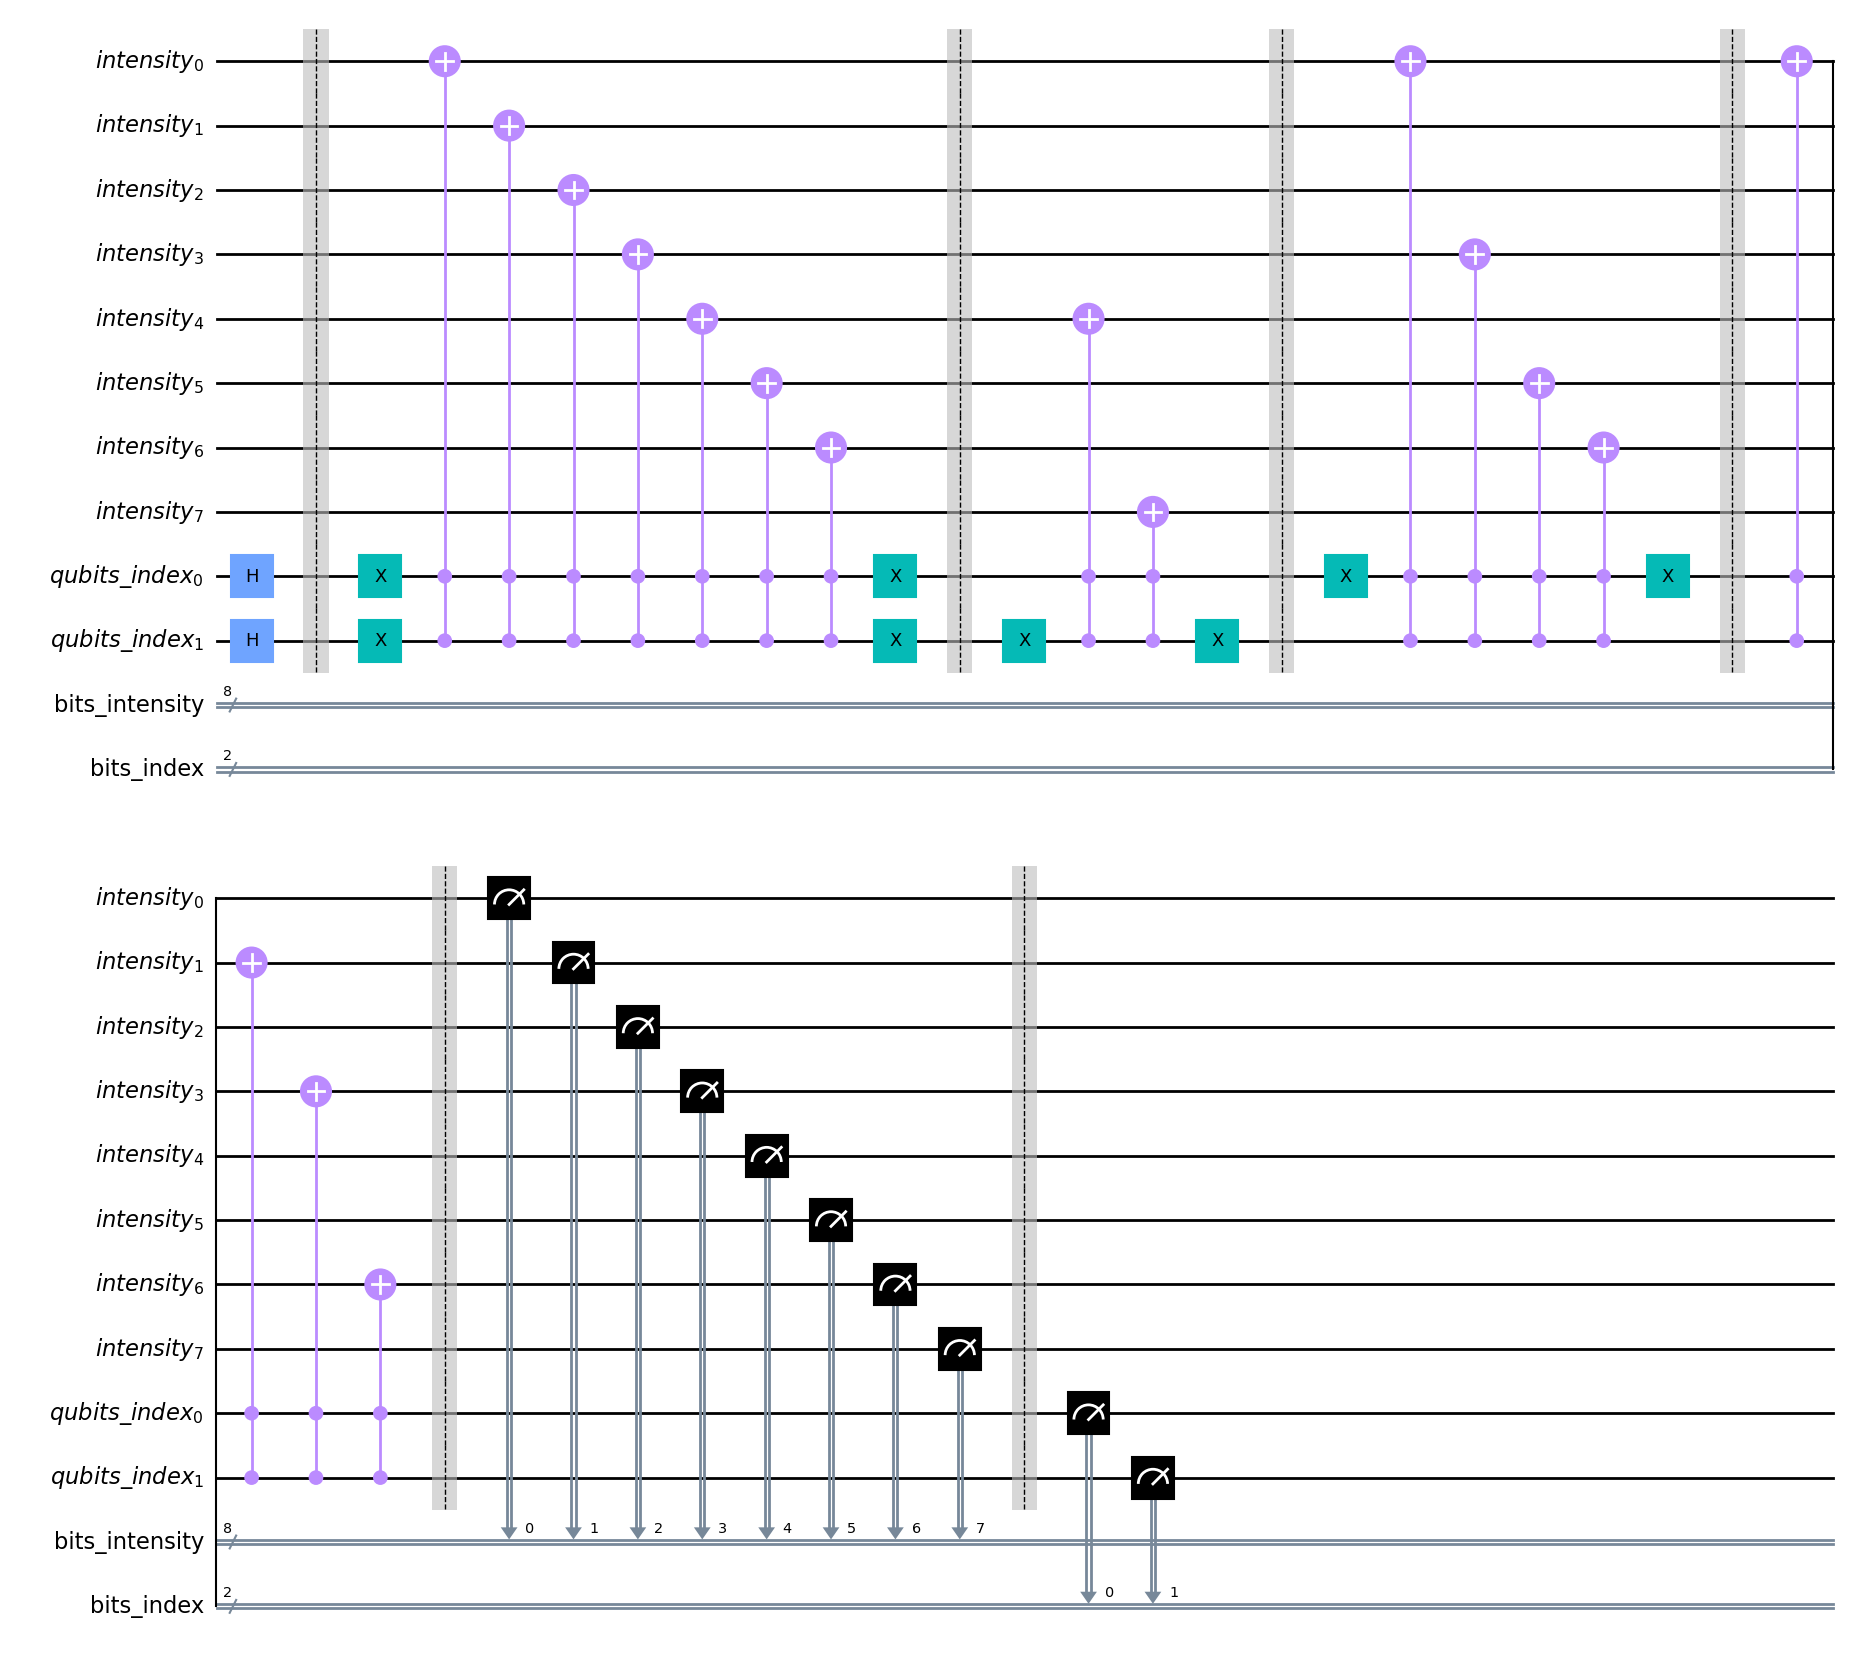

In [14]:
qcircuit.draw(output="mpl")

In [15]:
print("Circuit dimensions")
print(f"Circuit depth: {qcircuit.depth()}")
print(f"Circuit size: {qcircuit.size()}")
print(f"Circuit operations: {qcircuit.count_ops()}")

Circuit dimensions
Circuit depth: 26
Circuit size: 37
Circuit operations: OrderedDict([('ccx', 17), ('measure', 10), ('x', 8), ('barrier', 6), ('h', 2)])


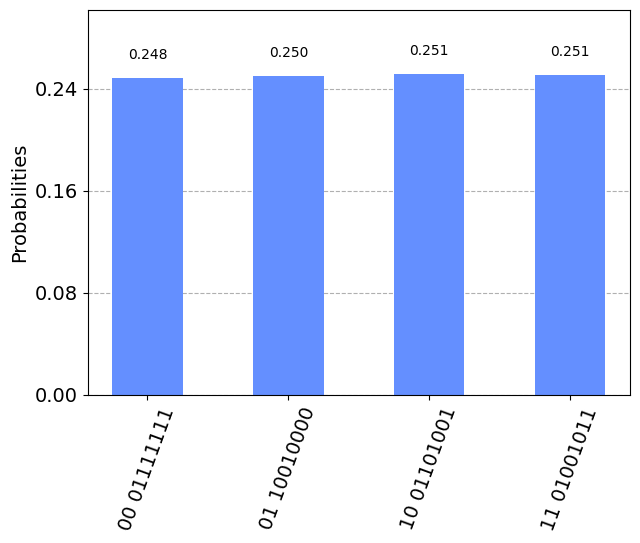

In [16]:
shots = 8192
backend = Aer.get_backend("qasm_simulator")
counts = execute(experiments=qcircuit, backend=backend, shots=shots).result().get_counts()
plot_histogram(counts)